In [14]:
import cv2
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from keras.utils import to_categorical
from keras.preprocessing.image import img_to_array
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator


from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.core import Dense, Dropout, Flatten, Activation

random.seed(42)

In [2]:
dataset = pd.read_csv("sample_labels.csv")
dataset.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
0,00000013_005.png,Emphysema|Infiltration|Pleural_Thickening|Pneu...,5,13,060Y,M,AP,3056,2544,0.139,0.139
1,00000013_026.png,Cardiomegaly|Emphysema,26,13,057Y,M,AP,2500,2048,0.168,0.168
2,00000017_001.png,No Finding,1,17,077Y,M,AP,2500,2048,0.168,0.168
3,00000030_001.png,Atelectasis,1,30,079Y,M,PA,2992,2991,0.143,0.143
4,00000032_001.png,Cardiomegaly|Edema|Effusion,1,32,055Y,F,AP,2500,2048,0.168,0.168


In [3]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5606 entries, 0 to 5605
Data columns (total 11 columns):
Image Index                    5606 non-null object
Finding Labels                 5606 non-null object
Follow-up #                    5606 non-null int64
Patient ID                     5606 non-null int64
Patient Age                    5606 non-null object
Patient Gender                 5606 non-null object
View Position                  5606 non-null object
OriginalImageWidth             5606 non-null int64
OriginalImageHeight            5606 non-null int64
OriginalImagePixelSpacing_x    5606 non-null float64
OriginalImagePixelSpacing_y    5606 non-null float64
dtypes: float64(2), int64(4), object(5)
memory usage: 481.8+ KB


In [4]:
dataset = dataset.iloc[:, [0, 1]]
dataset.sample(5)

,Image Index,Finding Labels
541,00002777_000.png,Effusion|Pleural_Thickening
4357,00021499_013.png,Edema|Effusion|Nodule
4189,00020534_001.png,No Finding
3908,00019265_003.png,Atelectasis|Effusion|Pneumothorax
2544,00012815_001.png,No Finding


In [5]:
dataset["Labels"] = dataset['Finding Labels'].apply(
    lambda x: "Normal" if x == "No Finding" else "Abnormal")
dataset["Encoded"] = dataset['Labels'].apply(
    lambda x: 1 if x == "Normal" else 0)
dataset.sample(5)

,Image Index,Finding Labels,Labels,Encoded
2600,00013062_004.png,Infiltration,Abnormal,0
1893,00009931_000.png,Effusion|Infiltration,Abnormal,0
3590,00017710_005.png,No Finding,Normal,1
258,00001373_026.png,Cardiomegaly,Abnormal,0
2021,00010530_010.png,No Finding,Normal,1


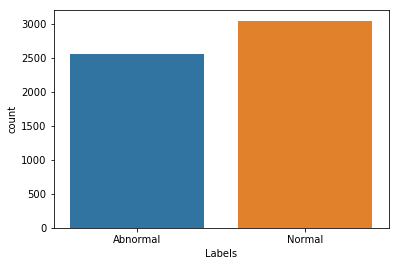

In [6]:
sns.countplot(x="Labels", data=dataset)

In [7]:
dataset.groupby(['Labels']).count()

,Image Index,Finding Labels,Encoded
Labels,,,
Abnormal,2562,2562,2562
Normal,3044,3044,3044


In [8]:
dataset = dataset.sort_values('Labels')
dataset.drop(dataset.tail(3044 - 2562).index, inplace=True)

In [9]:
dataset.groupby(['Labels']).count()

,Image Index,Finding Labels,Encoded
Labels,,,
Abnormal,2562,2562,2562
Normal,2562,2562,2562


In [10]:
IMAGE_DIMS = (96, 96, 3)

imagePaths = list(dataset.iloc[:, 0])

data = []

for imagePath in imagePaths:
    image = cv2.imread("images\\" + imagePath)
    image = cv2.resize(image, (IMAGE_DIMS[1], IMAGE_DIMS[0]))
    image = img_to_array(image)
    data.append(image)

label = list(dataset.iloc[:, 3])

print("Number of X-ray Images ", len(data))
print("Number of X-ray Labels ", len(label))

Number of X-ray Images  5124
Number of X-ray Labels  5124


(-0.5, 95.5, 95.5, -0.5)

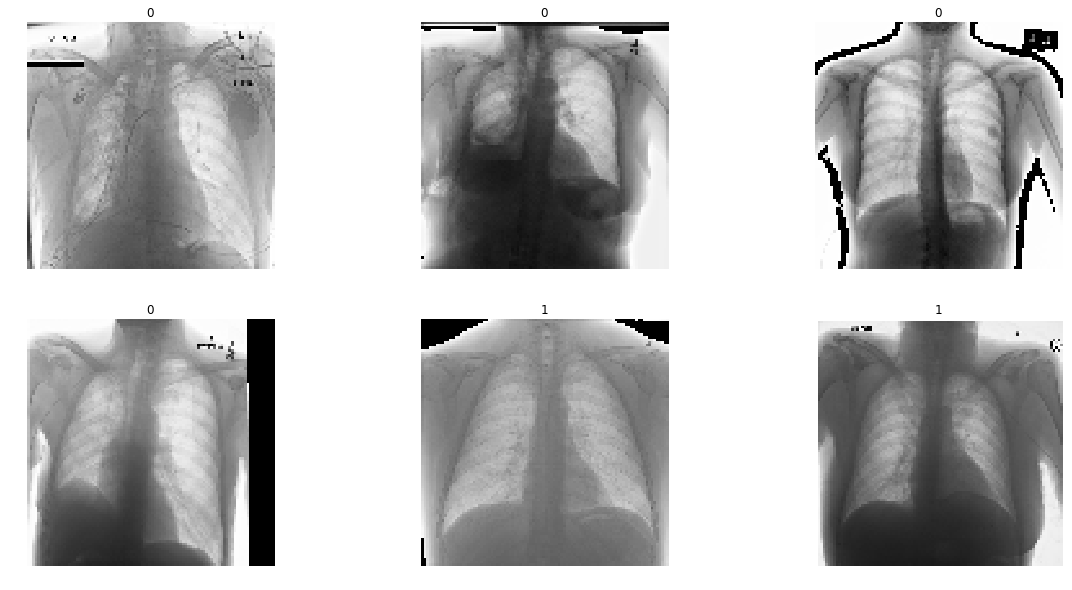

In [11]:
plt.figure(figsize=(20,10))
plt.subplot(231)
plt.imshow(data[0], cmap = 'bone'); plt.title(label[0]); plt.axis('off')
plt.subplot(232)
plt.imshow(data[1], cmap = 'bone'); plt.title(label[1]); plt.axis('off')
plt.subplot(233)
plt.imshow(data[2], cmap = 'bone'); plt.title(label[2]); plt.axis('off')
plt.subplot(234)
plt.imshow(data[3], cmap = 'bone'); plt.title(label[3]); plt.axis('off')
plt.subplot(235)
plt.imshow(data[-2], cmap = 'bone'); plt.title(label[-2]); plt.axis('off')
plt.subplot(236)
plt.imshow(data[-1], cmap = 'bone'); plt.title(label[-1]); plt.axis('off')

In [12]:
data = np.array(data, dtype="float") / 255.0
label = np.array(label)
label = to_categorical(label, num_classes = 2)

random.shuffle(data)
random.shuffle(label)

(trainX, testX, trainY, testY) = train_test_split(data, label, test_size=0.2, random_state=42)

print("Number of Train X data: ", trainX.shape[0])
print("Number of Train Y label: ", trainY.shape[0])
print("Number of Test X data: ", testX.shape[0])
print("Number of Test Y label: ", testY.shape[0])

Number of Train X data:  4099
Number of Train Y label:  4099
Number of Test X data:  1025
Number of Test Y label:  1025


In [18]:
inputShape = (96, 96, 3)

model = Sequential()

model.add(Conv2D(32, (3, 3), padding="same", input_shape = inputShape))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=-1))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=-1))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
 
model.add(Dense(2))
model.add(Activation("softmax"))

EPOCHS = 100
INIT_LR = 1e-3
BS = 64

optimize = Adam(lr = INIT_LR, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay = INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=optimize, metrics=["accuracy"])

In [20]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 96, 96, 32)        896       
_________________________________________________________________
activation_14 (Activation)   (None, 96, 96, 32)        0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 96, 96, 32)        128       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
activation_15 (Activation)   (None, 32, 32, 64)        0         
__________

In [21]:
aug = ImageDataGenerator(rotation_range=25, width_shift_range=0.1, height_shift_range=0.1, 
                         shear_range=0.2, zoom_range=0.2, horizontal_flip=True, fill_mode="nearest")

In [22]:
History = model.fit_generator(aug.flow(trainX, trainY, batch_size = BS), validation_data=(testX, testY), 
                        steps_per_epoch = len(trainX) // BS, epochs = EPOCHS, verbose = 1)

Epoch 1/100
64/64 [==============================] - 212s 3s/step - loss: 0.9597 - acc: 0.6366 - val_loss: 0.8973 - val_acc: 0.8546
Epoch 2/100
64/64 [==============================] - 229s 4s/step - loss: 0.5758 - acc: 0.7973 - val_loss: 1.3152 - val_acc: 0.8546
Epoch 3/100
64/64 [==============================] - 236s 4s/step - loss: 0.5692 - acc: 0.7973 - val_loss: 0.8983 - val_acc: 0.2176
Epoch 4/100
64/64 [==============================] - 234s 4s/step - loss: 0.5522 - acc: 0.8110 - val_loss: 0.4802 - val_acc: 0.8546
Epoch 5/100
64/64 [==============================] - 236s 4s/step - loss: 0.5170 - acc: 0.8183 - val_loss: 0.5205 - val_acc: 0.8546
Epoch 6/100
64/64 [==============================] - 240s 4s/step - loss: 0.5554 - acc: 0.7961 - val_loss: 1.2511 - val_acc: 0.8546
Epoch 7/100
64/64 [==============================] - 238s 4s/step - loss: 0.5679 - acc: 0.7976 - val_loss: 0.5896 - val_acc: 0.8546
Epoch 8/100
64/64 [==============================] - 236s 4s/step - loss: 0.

In [24]:
from keras.models import load_model

# Creates a HDF5 file 'my_model.h5'
model.save('final_model.h5')

In [26]:
scores_train = model.evaluate(trainX, trainY, verbose=2)
print("CNN Accuracy on Train Data: %.2f%%" % (scores_train[1]*100))

CNN Accuracy on Train Data: 78.38%


In [27]:
scores_test = model.evaluate(testX, testY, verbose=2)
print("CNN Accuracy on Test Data: %.2f%%" % (scores_test[1]*100))

CNN Accuracy on Test Data: 77.46%


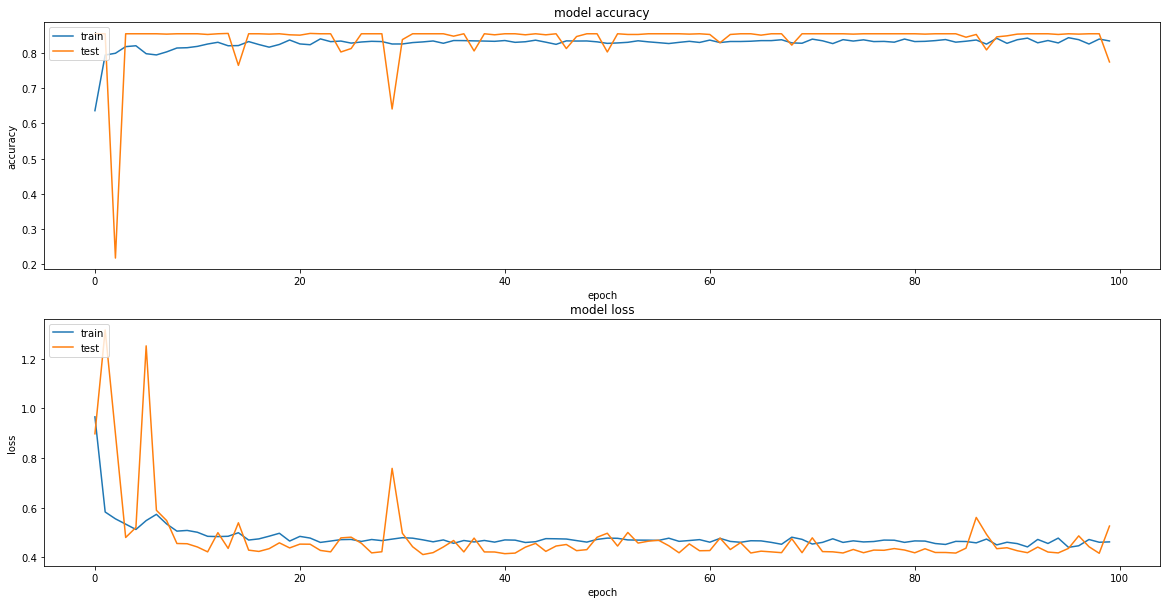

In [31]:
plt.figure(figsize=(20,10))
plt.subplot(211)
plt.plot(History.history['acc'])
plt.plot(History.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.subplot(212)
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')